In [1]:
%matplotlib notebook

In [2]:
!nvidia-smi

Thu Jul  2 10:12:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   32C    P8    23W / 250W |     12MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

import mlflow

from model.collectdata_mdsA import collect_data
from model.alt_loss_A import Loss
from model.training import trainNet, select_gpu
from model.model_02July2020 import SimpleCNN5Layer_Ca as Model
from model.training import trainNet, select_gpu, Results
from model.utilities import load_full_state, count_parameters
from model.plots import dual_train_plots, replace_in_ax
from model.utilities import count_parameters, Params
import hiddenlayer as HL
from torchsummary import summary

In [4]:
device = torch.device('cuda:1')    
mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('SimpleCNN5Layer_Ca')

In [5]:
train_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Aug14_80K_train.h5',
                            '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
                            '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
                            '/share/lazy/will/ML/June30_2020_80k_1.h5',
##                            'dataAA/Oct03_80K2_train.h5',
                             batch_size=64,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
                          batch_size=64,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Aug14_80K_train.h5 in 13.32 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 13.84 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5 in 6.767 s
Loaded /share/lazy/will/ML/June30_2020_80k_1.h5 in 13.37 s
Constructing 280000 event dataset took 0.9182 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.057 s
Constructing 9984 event dataset took 3.063 s


In [6]:
%%writefile architecture.txt
import torch
from torch import nn
import numpy as np

class SimpleCNN5Layer_Ca(nn.Module):
    ## same as SimpleCNN5Layer_C, except that sigmoid activation is replaced
    ## with Softplus activation
    softplus = torch.nn.Softplus()
    def __init__(self):
        super(SimpleCNN5Layer_Ca, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=20,
            kernel_size=25,
            stride=1,
            padding=(25 - 1) // 2,
        )

        assert (
            self.conv1.kernel_size[0] % 2 == 1
        ), "Kernel size should be odd for 'same' conv."

        self.conv2 = nn.Conv1d(
            in_channels=self.conv1.out_channels,
            out_channels=10,
            kernel_size=15,
            stride=1,
            padding=(15 - 1) // 2,
        )

        assert (
            self.conv2.kernel_size[0] % 2 == 1
        ), "Kernel size should be odd for 'same' conv."

        self.conv3 = nn.Conv1d(
            in_channels=self.conv2.out_channels,
            out_channels=10,
            kernel_size=15,
            stride=1,
            padding=(15 - 1) // 2,
        )

        assert (
            self.conv3.kernel_size[0] % 2 == 1
        ), "Kernel size should be odd for 'same' conv."

        self.conv4 = nn.Conv1d(
            in_channels=self.conv3.out_channels,
            out_channels=10,
            kernel_size=15,
            stride=1,
            padding=(15 - 1) // 2,
        )

        assert (
            self.conv4.kernel_size[0] % 2 == 1
        ), "Kernel size should be odd for 'same' conv."

        self.conv5 = nn.Conv1d(
            in_channels=self.conv4.out_channels,
            out_channels=1,
            kernel_size=5,
            stride=1,
            padding=(5 - 1) // 2,
        )

        assert (
            self.conv5.kernel_size[0] % 2 == 1
        ), "Kernel size should be odd for 'same' conv."

        self.conv1dropout = nn.Dropout(0.15)
        self.conv2dropout = nn.Dropout(0.15)
        self.conv3dropout = nn.Dropout(0.15)
        self.conv4dropout = nn.Dropout(0.15)
        self.conv5dropout = nn.Dropout(0.35)

        self.fc1 = nn.Linear(
            in_features=4000 * self.conv5.out_channels, out_features=4000
        )

    def forward(self, x):
        leaky = nn.LeakyReLU(0.01)
        x = leaky(self.conv1(x))
        x = self.conv1dropout(x)
        x = leaky(self.conv2(x))
        x = self.conv2dropout(x)
        x = leaky(self.conv3(x))
        x = self.conv3dropout(x)
        x = leaky(self.conv4(x))
        x = self.conv4dropout(x)
        x = leaky(self.conv5(x))

        # Remove empty middle shape diminsion
        x = x.view(x.shape[0], x.shape[-1])

        x = self.conv5dropout(x)
        x = self.fc1(x)

        x = self.softplus(x)

        return x

Overwriting architecture.txt


In [7]:
# params order - batch size, epochs, lr
runs = [
    (Model().to(device), Params(64, 20, 5e-5, 0)),
    #(Model(24).to(device), Params(64, 200, 5e-4, 0)),
    #(Model(16).to(device), Params(64, 200, 5e-4, 0)),
    #(Model(12).to(device), Params(64, 200, 5e-4, 0)),
    #(Model(24).to(device), Params(64, 200, 5e-3, 0)),
    #(Model(16).to(device), Params(64, 200, 5e-3, 0)),
    #(Model(12).to(device), Params(64, 200, 5e-3, 0)),
    #(Model(24).to(device), Params(64, 200, 1e-3, 0)),
    #(Model(16).to(device), Params(64, 200, 1e-3, 0)),
    #(Model(12).to(device), Params(64, 200, 1e-3, 0))
]

In [8]:
# Define optimizer and loss
loss = Loss(epsilon=1e-5,coefficient=2.5)
eff_avg = 0
fp_avg = 0

<IPython.core.display.Javascript object>


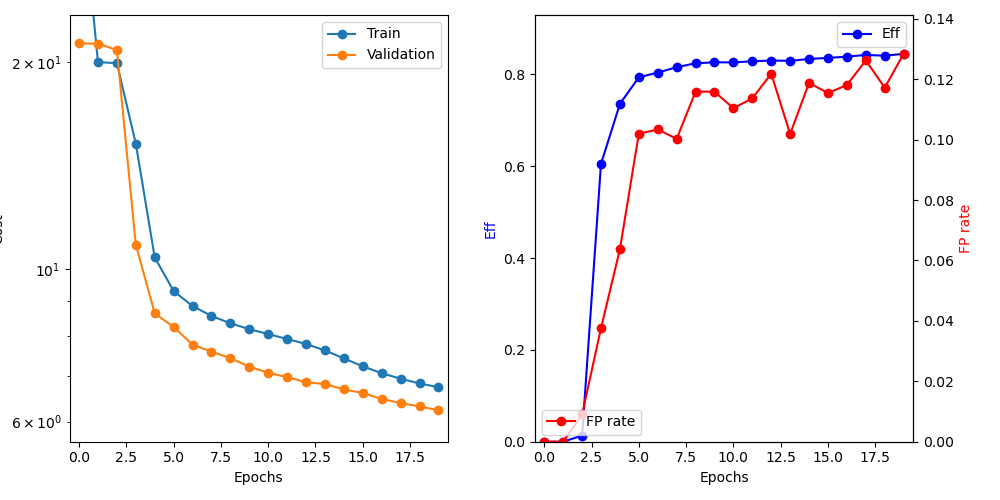

epoch_start 0
batch_size 64
epochs 20
lr 5e-05
=============================== HYPERPARAMETERS ================================
n_epochs: 20
batch_size: 64 events
dataset_train: 280000 events
dataset_val: 9984 events
loss: Loss()
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
model: SimpleCNN5Layer_Ca(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): L

In [9]:
# we need this for plots
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
results = pd.DataFrame([], columns=Results._fields)

for (model, args) in runs:
    run_name = 'SimpleCNN5Layer Test 2'

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    with mlflow.start_run(run_name = run_name) as run:

        for key, value in vars(args).items():
            print(key, value)
            mlflow.log_param(key, value)

        mlflow.log_param('Parameters', count_parameters(model))
        

        for result in trainNet(model, optimizer, loss,
                                train_loader, val_loader,
                                args.epochs+args.epoch_start, epoch_start=args.epoch_start, notebook=False, device=device):

            result = result._asdict()
            
            # plotting code block ===============================
            results = results.append(pd.Series(result), ignore_index=True)
            xs = results.index
            # Update the plot above
            lines['train'].set_data(results.index,results.cost)
            lines['val'].set_data(results.index,results.val)
            #filter first cost epoch (can be really large)
            max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
            
            min_cost = min(min(results.cost), min(results.val))
            # The plot limits need updating too
            ax.set_ylim(min_cost*.9, max_cost*1.1)  
            ax.set_xlim(-.5, len(results.cost) - .5)
            replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
            replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
            # Redraw the figure
#            fig.canvas.draw()
            fig.savefig('plot.png')
            # plotting code block =============================== 

            # Log metrics
            mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
            mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
            mlflow.log_metric('Validation Loss',  result['val']*2, result['epoch'])
            mlflow.log_metric('Training Loss',  result['cost']*2, result['epoch'])
            
            # Log tags
            mlflow.set_tag('Optimizer', 'Adam')
            mlflow.set_tag('Kernel size', 'Mixed')
            mlflow.set_tag('Skip connections', '4')
            mlflow.set_tag('Activation', 'Softplus')
            mlflow.set_tag('Mid Activation', 'Relu')

            # Save model AND optimizer state_dict AND epoch number. x
            torch.save({
                'model':model.state_dict(),
                'optimizer':optimizer.state_dict(),
                'epoch':args.epochs+result['epoch']
                }, 'run_stats.pyt')
            mlflow.log_artifact('run_stats.pyt')
            
            # save a diagram of the architecture
            HL.transforms.Fold("Conv > BatchNorm > LeakyRelu", "ConvBnRelu"),
            HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
            mlflow.log_artifact('architecture.png')
        
            # log the code for the model architecture
            mlflow.log_artifact('architecture.txt')
        
            # save plot that mike likes
            mlflow.log_artifact('plot.png')

In [10]:
##quit()